# Normal distribution 

The simplest model: the Normal distribution. It is used as a basic components in many more complex models.

In [1]:
using Pkg
Pkg.activate("../");

using LinearAlgebra
using Plots
using Random

import ExpFamilyDistributions
const EFD = ExpFamilyDistributions

using Revise
using BayesianModels

# Plotting function
include("plotting.jl");

  Activating environment at `~/Repositories/BayesianModels.jl/Project.toml`
┌ Info: Precompiling BayesianModels [1400088c-90aa-43b9-ae43-7211fec07595]
└ @ Base loading.jl:1317


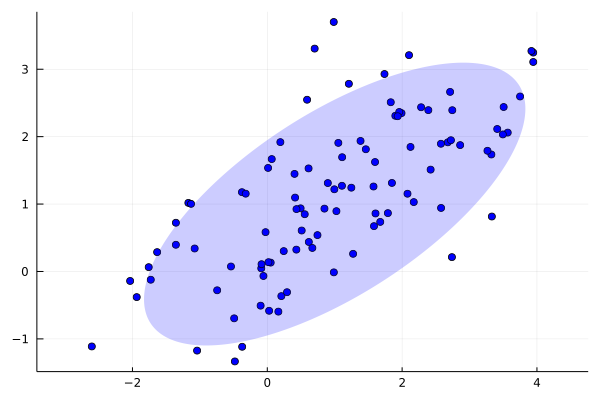

In [2]:
T = Float64
μₓ = T[1, 1] 
Σₓ = T[2 1; 1.0  1.1]

function draw(n, μ, Σ)
    L = cholesky(Σ).L
    hcat([μ + L*randn(T, 2) for i in 1:n]...)
end


X = draw(100, μₓ, Σₓ)
p = plot(legend = false, aspect_ratio = 1)
scatter!(X[1,:], X[2,:], color = :blue)
plotnormal!(μₓ, Σₓ, σ = 2, color = :blue, linewidth = 0, fillalpha = 0.2)

In [21]:
X = randn(39, 1000)
D = size(X, 1)

model = BayesianModels.Normal(D)
params = filter(isbayesianparam, getparams(model))

2-element Vector{BayesianParameter{DT1, DT2, Vector{Float64}} where {DT1, DT2}}:
 BayesianParameter{ExpFamilyDistributions.Wishart{ExpFamilyDistributions.DefaultParameter{Vector{Float64}}, 39}, ExpFamilyDistributions.Wishart{ExpFamilyDistributions.DefaultParameter{Vector{Float64}}, 39}, Vector{Float64}}(ExpFamilyDistributions.Wishart{ExpFamilyDistributions.DefaultParameter{Vector{Float64}}, 39}(ExpFamilyDistributions.DefaultParameter{Vector{Float64}}([-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 19.5])), ExpFamilyDistributions.Wishart{ExpFamilyDistributions.DefaultParameter{Vector{Float64}}, 39}(ExpFamilyDistributions.DefaultParameter{Vector{Float64}}([-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 19.5])), [39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 101.90975057822712])
 BayesianPa

In [20]:
∇elbo(model, X; params)

(-1.1186747672010248e6, Dict{Any, Any}(BayesianParameter{ExpFamilyDistributions.Wishart{ExpFamilyDistributions.DefaultParameter{Vector{Float64}}, 34}, ExpFamilyDistributions.Wishart{ExpFamilyDistributions.DefaultParameter{Vector{Float64}}, 34}, Vector{Float64}}(ExpFamilyDistributions.Wishart{ExpFamilyDistributions.DefaultParameter{Vector{Float64}}, 34}(ExpFamilyDistributions.DefaultParameter{Vector{Float64}}([-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 17.0])), ExpFamilyDistributions.Wishart{ExpFamilyDistributions.DefaultParameter{Vector{Float64}}, 34}(ExpFamilyDistributions.DefaultParameter{Vector{Float64}}([-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 17.0])), [34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 83.99537333936755]) => [-1009.4633743231987, -1019.4893006383912, -981.8418

In [20]:
D = 2
model_full = BayesianModels.Normal(D)
model_diag = BayesianModels.NormalDiag(D)

BayesianModels.NormalDiagIndependentParams (
  (μ): BayesianParameter
  (λ): [
    (1): BayesianParameter
    (2): BayesianParameter
  ]
)


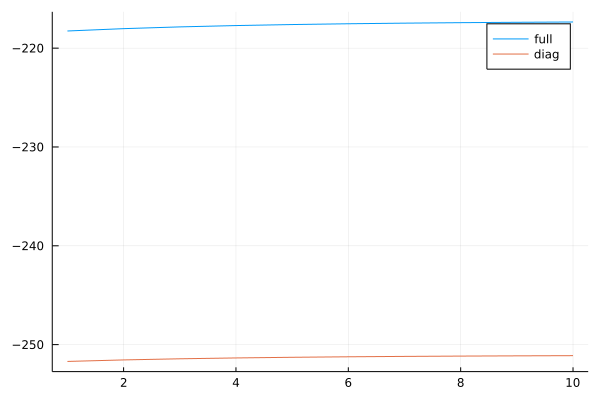

In [23]:
function fit(model, X; lrate = 0.1, steps = 1)
    elbos = []
    params = filter(isbayesianparam, getparams(model))

    for step in 1:steps
        𝓛, ∇ξ = ∇elbo(model, X, params = params)
        gradstep(∇ξ, lrate = lrate)
        push!(elbos, 𝓛)
    end
    elbos
end


elbos_full = fit(model_full, X, steps = 10)
elbos_diag = fit(model_diag, X, steps = 10)
plot(elbos_full, label = "full")
plot!(elbos_diag, label = "diag")

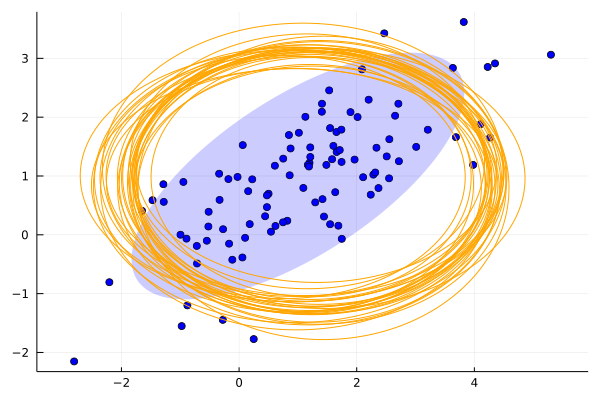

In [26]:
p = plot(legend = false, aspect_ratio = 1)
scatter!(X[1,:], X[2,:], color = :blue)
plotnormal!(μₓ, Σₓ, σ = 2, color = :blue, linecolor = :blue, linewidth = 0, fillalpha = 0.2)

μs = EFD.sample(model_diag.μ.posterior, 30)
#Σs = [inv(Λₗ) for Λₗ in EFD.sample(model.Λ.posterior, 30)]
Σs = [diagm(1 ./ λₗ) for λₗ in eachrow(hcat(EFD.sample.(getproperty.(model_diag.λ, :posterior), 30)...))]
for (μ, Σ) in zip(μs, Σs)
    plotnormal!(μ, Σ, σ = 2, color = :orange, linecolor = :orange, fillalpha = 0)
end

p

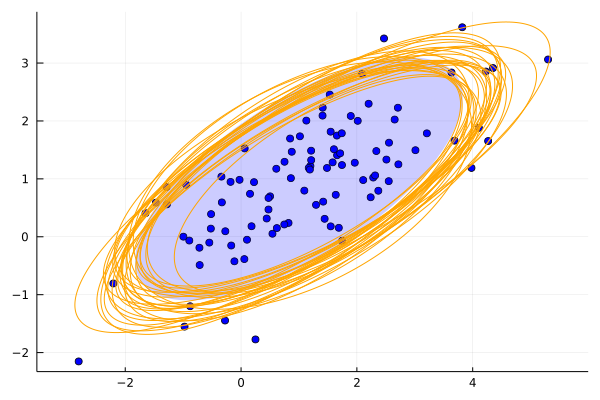

In [27]:
p = plot(legend = false, aspect_ratio = 1)
scatter!(X[1,:], X[2,:], color = :blue)
plotnormal!(μₓ, Σₓ, σ = 2, color = :blue, linecolor = :blue, linewidth = 0, fillalpha = 0.2)

μs = EFD.sample(model_full.μ.posterior, 30)
Σs = [inv(Λₗ) for Λₗ in EFD.sample(model_full.Λ.posterior, 30)]
#Σs = [diagm(1 ./ λₗ) for λₗ in eachrow(hcat(EFD.sample.(getproperty.(model.λ, :posterior), 30)...))]
for (μ, Σ) in zip(μs, Σs)
    plotnormal!(μ, Σ, σ = 2, color = :orange, linecolor = :orange, fillalpha = 0)
end

p

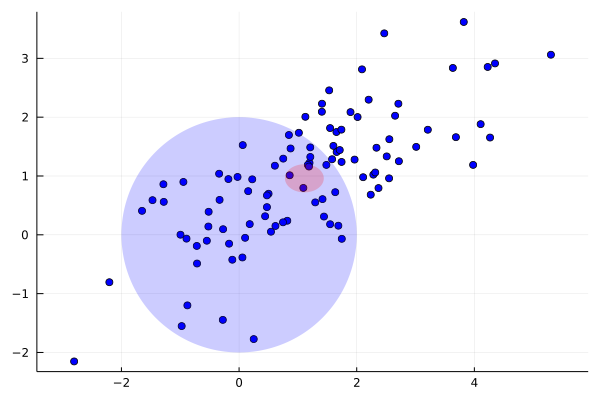

In [28]:
p = plot(legend = false, aspect_ratio = 1)
scatter!(X[1,:], X[2,:], color = :blue)
plotnormal!(model_diag.μ.prior.μ, model_diag.μ.prior.Σ, σ = 2, color = :blue, linecolor = :blue, linewidth = 0, fillalpha = 0.2)
plotnormal!(model_diag.μ.posterior.μ, model_diag.μ.posterior.Σ, σ = 2, color = :red, linecolor = :red, linewidth = 0, fillalpha = 0.2)

p

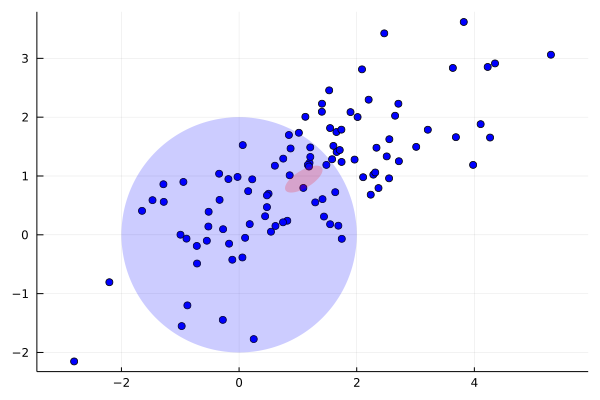

In [29]:
p = plot(legend = false, aspect_ratio = 1)
scatter!(X[1,:], X[2,:], color = :blue)
plotnormal!(model_full.μ.prior.μ, model_full.μ.prior.Σ, σ = 2, color = :blue, linecolor = :blue, linewidth = 0, fillalpha = 0.2)
plotnormal!(model_full.μ.posterior.μ, model_full.μ.posterior.Σ, σ = 2, color = :red, linecolor = :red, linewidth = 0, fillalpha = 0.2)

p